# Topic Modeling

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both.

Topic modeling is a technique of extracting hidden topics from a volume of text. Topic modeling is a classic solution to the problem of information retrieval using linked data and semantic web technology. Related models and techniques are, among others, latent semantic indexing, independent component analysis, probabilistic latent semantic indexing, non-negative matrix factorization, Gamma-Poisson distribution and Latent Derichlet Allocation (LDA). Source: <a href='https://en.wikipedia.org/wiki/Topic_model'>wikipedia</a>

### Import required libraries

In [1]:
# !pip install pyLDAvis # Uncomment and install this visualization library

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Data manipulation
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint

# Data preprocessing & cleaning
import re
import string
from nltk.corpus import stopwords
from nltk import pos_tag, WordNetLemmatizer
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from sklearn.feature_extraction.text import CountVectorizer

# Modeling
import gensim
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Model Evaluation
from gensim.models import CoherenceModel

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 

In [4]:
plt.style.use('ggplot')

### Load dataset

We will use 20-Newsgroups dataset. The dataset contains around 11k newsgroups posts from 20 different topics. The dataset is found here <a href='https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'>newsgroups</a>

In [5]:
# df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df=pd.read_csv('newsgroups.csv')

In [6]:
df=df.head(500)

Check firt 5 rows 

In [7]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,rec.autos
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
3,100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
4,1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\r...,2,comp.os.ms-windows.misc


Check rows and columns

In [8]:
df.shape

(500, 4)

### Preprocess Data

Convert the text into lower case

In [9]:
def convert_to_lower_case(text):
    return "".join([t.lower() for t in text])

In [10]:
df['content']=df['content'].apply(lambda x: convert_to_lower_case(x))

In [11]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from: lerxst@wam.umd.edu (where's my thing)\r\...,7,rec.autos
1,1,from: guykuo@carson.u.washington.edu (guy kuo)...,4,comp.sys.mac.hardware
2,10,from: irwin@cmptrc.lonestar.org (irwin arnstei...,8,rec.motorcycles
3,100,from: tchen@magnus.acs.ohio-state.edu (tsung-k...,6,misc.forsale
4,1000,from: dabl2@nlm.nih.gov (don a.b. lindbergh)\r...,2,comp.os.ms-windows.misc


Remove emails

In [12]:
def remove_emails(text):
    data = ' '.join([item for item in text.split() if '@' not in item])
    return data

In [13]:
df['content']=df['content'].apply(lambda x: remove_emails(x))

In [14]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from: (where's my thing) subject: what car is ...,7,rec.autos
1,1,from: (guy kuo) subject: si clock poll - final...,4,comp.sys.mac.hardware
2,10,from: (irwin arnstein) subject: re: recommenda...,8,rec.motorcycles
3,100,from: (tsung-kun chen) subject: ** software fo...,6,misc.forsale
4,1000,from: (don a.b. lindbergh) subject: diamond ss...,2,comp.os.ms-windows.misc


Remove new line characters

In [15]:
def remove_line_character(text):
    data=text.rstrip()
    return data

In [16]:
df['content']=df['content'].apply(lambda x: remove_line_character(x))

In [17]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from: (where's my thing) subject: what car is ...,7,rec.autos
1,1,from: (guy kuo) subject: si clock poll - final...,4,comp.sys.mac.hardware
2,10,from: (irwin arnstein) subject: re: recommenda...,8,rec.motorcycles
3,100,from: (tsung-kun chen) subject: ** software fo...,6,misc.forsale
4,1000,from: (don a.b. lindbergh) subject: diamond ss...,2,comp.os.ms-windows.misc


Remove single quotes

Alternatively can use punctuation function

In [18]:
def remove_single_quotes(text):
    data=text.replace("'", "")
    return data

In [19]:
df['content']=df['content'].apply(lambda x: remove_single_quotes(x))

In [20]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from: (wheres my thing) subject: what car is t...,7,rec.autos
1,1,from: (guy kuo) subject: si clock poll - final...,4,comp.sys.mac.hardware
2,10,from: (irwin arnstein) subject: re: recommenda...,8,rec.motorcycles
3,100,from: (tsung-kun chen) subject: ** software fo...,6,misc.forsale
4,1000,from: (don a.b. lindbergh) subject: diamond ss...,2,comp.os.ms-windows.misc


Remove Punctuations

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

In [23]:
df['content']=df['content'].apply(lambda x: remove_punctuation(x))

In [24]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from wheres my thing subject what car is this ...,7,rec.autos
1,1,from guy kuo subject si clock poll final call...,4,comp.sys.mac.hardware
2,10,from irwin arnstein subject re recommendation ...,8,rec.motorcycles
3,100,from tsungkun chen subject software forsale l...,6,misc.forsale
4,1000,from don ab lindbergh subject diamond ss24x wi...,2,comp.os.ms-windows.misc


Remove words with less than 3 characters

In [25]:
def words_less_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>2])

In [26]:
df['content']=df['content'].apply(lambda x: words_less_than_three_chars(x))

In [27]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,from wheres thing subject what car this nntppo...,7,rec.autos
1,1,from guy kuo subject clock poll final call sum...,4,comp.sys.mac.hardware
2,10,from irwin arnstein subject recommendation duc...,8,rec.motorcycles
3,100,from tsungkun chen subject software forsale lo...,6,misc.forsale
4,1000,from don lindbergh subject diamond ss24x win m...,2,comp.os.ms-windows.misc


Tokenize the text

In [28]:
def text_tokenizaion(text):
    return re.split(' ',text)

In [29]:
df['content']=df['content'].apply(lambda x: text_tokenizaion(x))

In [30]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,"[from, wheres, thing, subject, what, car, this...",7,rec.autos
1,1,"[from, guy, kuo, subject, clock, poll, final, ...",4,comp.sys.mac.hardware
2,10,"[from, irwin, arnstein, subject, recommendatio...",8,rec.motorcycles
3,100,"[from, tsungkun, chen, subject, software, fors...",6,misc.forsale
4,1000,"[from, don, lindbergh, subject, diamond, ss24x...",2,comp.os.ms-windows.misc


Remove stopword
Comment this section when using Extracts Nouns only function

In [31]:
def remove_stopwords(text):
    return [w for w in text if w not in stopwords.words('english')]

In [32]:
df['content']=df['content'].apply(lambda x: remove_stopwords(x))

In [33]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,"[wheres, thing, subject, car, nntppostinghost,...",7,rec.autos
1,1,"[guy, kuo, subject, clock, poll, final, call, ...",4,comp.sys.mac.hardware
2,10,"[irwin, arnstein, subject, recommendation, duc...",8,rec.motorcycles
3,100,"[tsungkun, chen, subject, software, forsale, l...",6,misc.forsale
4,1000,"[lindbergh, subject, diamond, ss24x, win, mous...",2,comp.os.ms-windows.misc


Extracts Nouns only

In [34]:
def extract_nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    all_nouns = ' '.join([word for (word, pos) in pos_tag(text) if is_noun(pos)])
    return all_nouns

In [35]:
df['content']=df['content'].apply(lambda x: extract_nouns(x))

In [36]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,wheres thing car nntppostinghost rac3wamumdedu...,7,rec.autos
1,1,guy kuo clock poll call call clock reports key...,4,comp.sys.mac.hardware
2,10,irwin arnstein recommendation duc whats distri...,8,rec.motorcycles
3,100,tsungkun chen software lots organization ohio ...,6,misc.forsale
4,1000,lindbergh diamond ss24x win mouse cursor organ...,2,comp.os.ms-windows.misc


In [37]:
df['content']=df['content'].apply(lambda x: text_tokenizaion(x))

Normalize text by Lemmatization

In [38]:
def text_lematization(text):
    return [WordNetLemmatizer().lemmatize(w) for w in text]

In [39]:
df['content']=df['content'].apply(lambda x: text_lematization(x))

In [40]:
df.head()

,Unnamed: 0,content,target,target_names
0,0,"[wheres, thing, car, nntppostinghost, rac3wamu...",7,rec.autos
1,1,"[guy, kuo, clock, poll, call, call, clock, rep...",4,comp.sys.mac.hardware
2,10,"[irwin, arnstein, recommendation, duc, whats, ...",8,rec.motorcycles
3,100,"[tsungkun, chen, software, lot, organization, ...",6,misc.forsale
4,1000,"[lindbergh, diamond, ss24x, win, mouse, cursor...",2,comp.os.ms-windows.misc


Convert data to list for modeling

In [41]:
data = df.content.values.tolist()
tokenized_data = df.content.values.tolist()

In [42]:
print(tokenized_data[0:2])

[['wheres', 'thing', 'car', 'nntppostinghost', 'rac3wamumdedu', 'organization', 'university', 'college', 'park', 'line', 'anyone', 'car', 'day', 'sport', 'car', 'bricklin', 'door', 'addition', 'bumper', 'rest', 'body', 'anyone', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'history', 'info', 'funky', 'car', 'please', 'email', 'thanks', 'neighborhood', 'lerxst'], ['guy', 'kuo', 'clock', 'poll', 'call', 'call', 'clock', 'report', 'keywords', 'organization', 'university', 'washington', 'line', 'number', 'soul', 'clock', 'oscillator', 'experience', 'poll', 'message', 'experience', 'procedure', 'speed', 'cpu', 'add', 'card', 'adapter', 'sink', 'hour', 'day', 'disk', 'functionality', 'floppy', 'day', 'network', 'knowledge', 'base', 'clock', 'havent', 'thanks']]


### Create Data Input to Model

1. Create Dictionary

In [43]:
id2word = corpora.Dictionary(tokenized_data)

In [44]:
id2word

2. Create Corpus (Term Document Frequency)

In [45]:
corpus = [id2word.doc2bow(text) for text in tokenized_data]

In [46]:
print(corpus[0:2])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(7, 2), (15, 1), (20, 1), (28, 1), (30, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 4), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)]]


Show corpus and frequency

In [47]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('addition', 1), ('anyone', 2), ('body', 1), ('bricklin', 1), ('bumper', 1), ('car', 5), ('college', 1), ('day', 1), ('door', 1), ('email', 1), ('engine', 1), ('funky', 1), ('history', 1), ('info', 1), ('lerxst', 1), ('line', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntppostinghost', 1), ('organization', 1), ('park', 1), ('please', 1), ('production', 1), ('rac3wamumdedu', 1), ('rest', 1), ('spec', 1), ('sport', 1), ('thanks', 1), ('thing', 1), ('university', 1), ('wheres', 1), ('year', 1)]]


### Modeling LDA Topic model

#### Latent Dirichlet allocation (LDA)

Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning toolbox and in wider sense to the artificial intelligence toolbox. Source: <a href='https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation'>wikipedia</a>

In the LDA model below we specify chunksize which is the number of document to use for each training iteration/chunk. passes is the total number of training pass.

In [48]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=6, random_state=100, update_every=1,
                                           chunksize=100,passes=10,alpha='auto',per_word_topics=True)

Show topics

Each keyword has a weighted importance value

In [49]:
pprint(model.print_topics())

[(0,
  '0.012*"key" + 0.011*"god" + 0.010*"line" + 0.010*"ripem" + '
  '0.009*"organization" + 0.009*"message" + 0.007*"use" + 0.007*"way" + '
  '0.006*"chip" + 0.006*"article"'),
 (1,
  '0.012*"drive" + 0.010*"file" + 0.010*"line" + 0.008*"card" + '
  '0.008*"organization" + 0.007*"price" + 0.007*"device" + 0.006*"window" + '
  '0.006*"controller" + 0.006*"application"'),
 (2,
  '0.021*"people" + 0.008*"person" + 0.008*"section" + 0.008*"article" + '
  '0.008*"weapon" + 0.008*"law" + 0.008*"gun" + 0.007*"state" + '
  '0.007*"government" + 0.007*"thing"'),
 (3,
  '0.024*"line" + 0.021*"organization" + 0.011*"university" + 0.007*"detector" '
  '+ 0.007*"distribution" + 0.007*"article" + 0.007*"car" + 0.006*"thanks" + '
  '0.006*"sale" + 0.006*"radar"'),
 (4,
  '0.018*"line" + 0.018*"organization" + 0.012*"article" + 0.010*"team" + '
  '0.008*"player" + 0.007*"year" + 0.007*"time" + 0.007*"game" + '
  '0.006*"window" + 0.006*"university"'),
 (5,
  '0.014*"line" + 0.012*"organization" + 0

### Model Evaluation

1. Model perplexity

In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. <a href='https://en.wikipedia.org/wiki/Perplexity'>wikipedia</a>

In [50]:
model.log_perplexity(corpus)

-8.23682054275583

2. Topic Coherence 

Topic coherence is a metric that returns the coherene score with is a measure of the degree of semantic similarity between high scoring words in the topic

In [51]:
model_coherence = CoherenceModel(model=model, texts=tokenized_data, dictionary=id2word, coherence='c_v')

In [52]:
model_coherence.get_coherence()

0.3263665774365478

### Visualize the topics

In [53]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(model, corpus, id2word)

In [54]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.205823 -0.001243       1        1  26.444223
0     -0.037545 -0.164952       2        1  16.424234
5     -0.065406  0.047584       3        1  15.702659
4      0.060674  0.081671       4        1  14.462994
1      0.180227 -0.096118       5        1  13.954342
3      0.067872  0.133057       6        1  13.011554, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
250   Default  244.000000           people  244.000000  30.0000  30.0000
2057  Default   69.000000              key   69.000000  29.0000  29.0000
166   Default   60.000000            drive   60.000000  28.0000  28.0000
118   Default  132.000000            state  132.000000  27.0000  27.0000
277   Default   70.000000              god   70.000000  26.0000  26.0000
7433  Default   54.000000            ripem   54.000000  25.0000  25.0000
2447  Default   71.000000           weapon   71.000000  24.0000  24.0000
332   Default   54.000000             team   54.000000  23.0000  23.0000
1285  Default   68.000000              gun   68.000000  22.0000  22.0000
437   Default   54.000000             file   54.000000  21.0000  21.0000
15    Default  425.000000             line  425.000000  20.0000  20.0000
1971  Default   40.000000           player   40.000000  19.0000  19.0000
20    Default  384.000000     organization  384.000000  18.0000  18.0000
816   Default   80.000000          section   80.000000  17.0000  17.0000
128   Default   59.000000           window   59.000000  16.0000  16.0000
2787  Default   59.000000          firearm   59.000000  15.0000  15.0000
37    Default   45.000000             card   45.000000  14.0000  14.0000
2702  Default   33.000000         detector   33.000000  13.0000  13.0000
240   Default   52.000000            crime   52.000000  12.0000  12.0000
444   Default   89.000000              law   89.000000  11.0000  11.0000
183   Default   93.000000           person   93.000000  10.0000  10.0000
28    Default   65.000000           thanks   65.000000   9.0000   9.0000
50    Default   66.000000          message   66.000000   8.0000   8.0000
253   Default   48.000000             rate   48.000000   7.0000   7.0000
1606  Default   45.000000             game   45.000000   6.0000   6.0000
1491  Default   38.000000             chip   38.000000   5.0000   5.0000
2328  Default   29.000000       controller   29.000000   4.0000   4.0000
1271  Default   63.000000          control   63.000000   3.0000   3.0000
2453  Default   38.000000           device   38.000000   2.0000   2.0000
610   Default   45.000000         division   45.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
900    Topic6   18.543159             food   22.890488   1.8287  -5.4610
546    Topic6   16.530474              box   20.652802   1.8167  -5.5759
1111   Topic6   22.005116            space   28.654171   1.7753  -5.2898
5      Topic6   28.895750              car   39.077591   1.7375  -5.0174
410    Topic6   24.574181             sale   33.814495   1.7201  -5.1794
1362   Topic6   15.266521             paul   19.439011   1.7977  -5.6554
2079   Topic6   23.994890             list   33.959793   1.6920  -5.2032
660    Topic6   22.941170             mark   33.538731   1.6596  -5.2481
9      Topic6   20.682125            email   37.149017   1.4537  -5.3518
15     Topic6  104.548439             line  425.090912   0.6367  -3.7314
20     Topic6   92.760567     organization  384.571777   0.6172  -3.8511
28     Topic6   27.883936           thanks   65.830368   1.1803  -5.0530
164    Topic6   11.156681           design   15.475421   1.7121  -5.9690
30     Topic6   47.792484       university  188.049789   0.6695  -4.5142
320    Topic6   12.381287          station   19.645983   1.5776  -5.8649
69     Topic6   32.28

##### Interpreting the Visual

Each bubble on the left graph represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

### 1. Dominant topic in each sentence

To get the dominant topic in each sentence we compute the percentage contribution of each topic.

In [55]:
def topics_in_sentences(model=None, corpus=corpus, texts=data):
    # Initialize an empty dataframe
    sentence_topics_df = pd.DataFrame()

    # Loop through each document and each sentence to get the key topics
    for i, row_list in enumerate(model[corpus]):
        row = row_list[0] if model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # For each document extract the topic percentage contribution and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sentence_topics_df = sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sentence_topics_df.columns = ['Dominant_Topic', 'Pct_Contribution', 'Topic_Keywords']

    # Append original text to the end of the output
    contents = pd.Series(texts)
    sentence_topics_df = pd.concat([sentence_topics_df, contents], axis=1)
    return(sentence_topics_df)


sentence_topics_keywords_df = topics_in_sentences(model=model, corpus=corpus, texts=tokenized_data)

# Format
dominant_topic_df = sentence_topics_keywords_df.reset_index()
dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Pct_Contribution', 'Keywords', 'Text']

In [56]:
dominant_topic_df.head()

,Document_No,Dominant_Topic,Topic_Pct_Contribution,Keywords,Text
0,0,3.0,0.6543,"line, organization, university, detector, dist...","[wheres, thing, car, nntppostinghost, rac3wamu..."
1,1,1.0,0.6689,"drive, file, line, card, organization, price, ...","[guy, kuo, clock, poll, call, call, clock, rep..."
2,2,3.0,0.9783,"line, organization, university, detector, dist...","[irwin, arnstein, recommendation, duc, whats, ..."
3,3,1.0,0.9256,"drive, file, line, card, organization, price, ...","[tsungkun, chen, software, lot, organization, ..."
4,4,5.0,0.9732,"line, organization, state, system, university,...","[lindbergh, diamond, ss24x, win, mouse, cursor..."


### 2. The most representative sentence for each topic

In [57]:
# pd.options.display.max_colwidth = 100

sorted_sentence_topics_df = pd.DataFrame()
grouped_sentence_topics_df = sentence_topics_keywords_df.groupby('Dominant_Topic')

for i, grp in grouped_sentence_topics_df:
    sorted_sentence_topics_df = pd.concat([sorted_sentence_topics_df, 
                                             grp.sort_values(['Pct_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sorted_sentence_topics_df.reset_index(drop=True, inplace=True)

# Format columns
sorted_sentence_topics_df.columns = ['Topic_Num', "Topic_Pct_Contrib", "Keywords", "Representative Text"]

In [58]:
sorted_sentence_topics_df.head(10)

,Topic_Num,Topic_Pct_Contrib,Keywords,Representative Text
0,0.0,0.9919,"key, god, line, ripem, organization, message, ...","[mark, dotson, fragmentation, organization, da..."
1,1.0,0.9990,"drive, file, line, card, organization, price, ...","[response, request, bitmap, cliff, replyto, cl..."
2,2.0,0.9976,"people, person, section, article, weapon, law,...","[veal, fillibuster, line, organization, univer..."
3,3.0,0.9783,"line, organization, university, detector, dist...","[irwin, arnstein, recommendation, duc, whats, ..."
4,4.0,0.9900,"line, organization, article, team, player, yea...","[yankee, surprise, organization, dept, ithaca,..."
5,5.0,0.9914,"line, organization, state, system, university,...","[tammy, healy, note, bobby, line, organization..."


### 3. Topic distribution across documents

In [59]:
# Number of Documents for Each Topic
topic_counts = sentence_topics_keywords_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sentence_topics_keywords_df[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
dominant_topics_df = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
dominant_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Pct_Documents']

In [60]:
dominant_topics_df.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Pct_Documents
0,3.0,"line, organization, university, detector, dist...",73.0,0.146
1,1.0,"drive, file, line, card, organization, price, ...",75.0,0.150
2,3.0,"line, organization, university, detector, dist...",78.0,0.156
3,1.0,"drive, file, line, card, organization, price, ...",110.0,0.220
4,5.0,"line, organization, state, system, university,...",94.0,0.188


### 4. Word Clouds of Top N Keywords in Each Topic

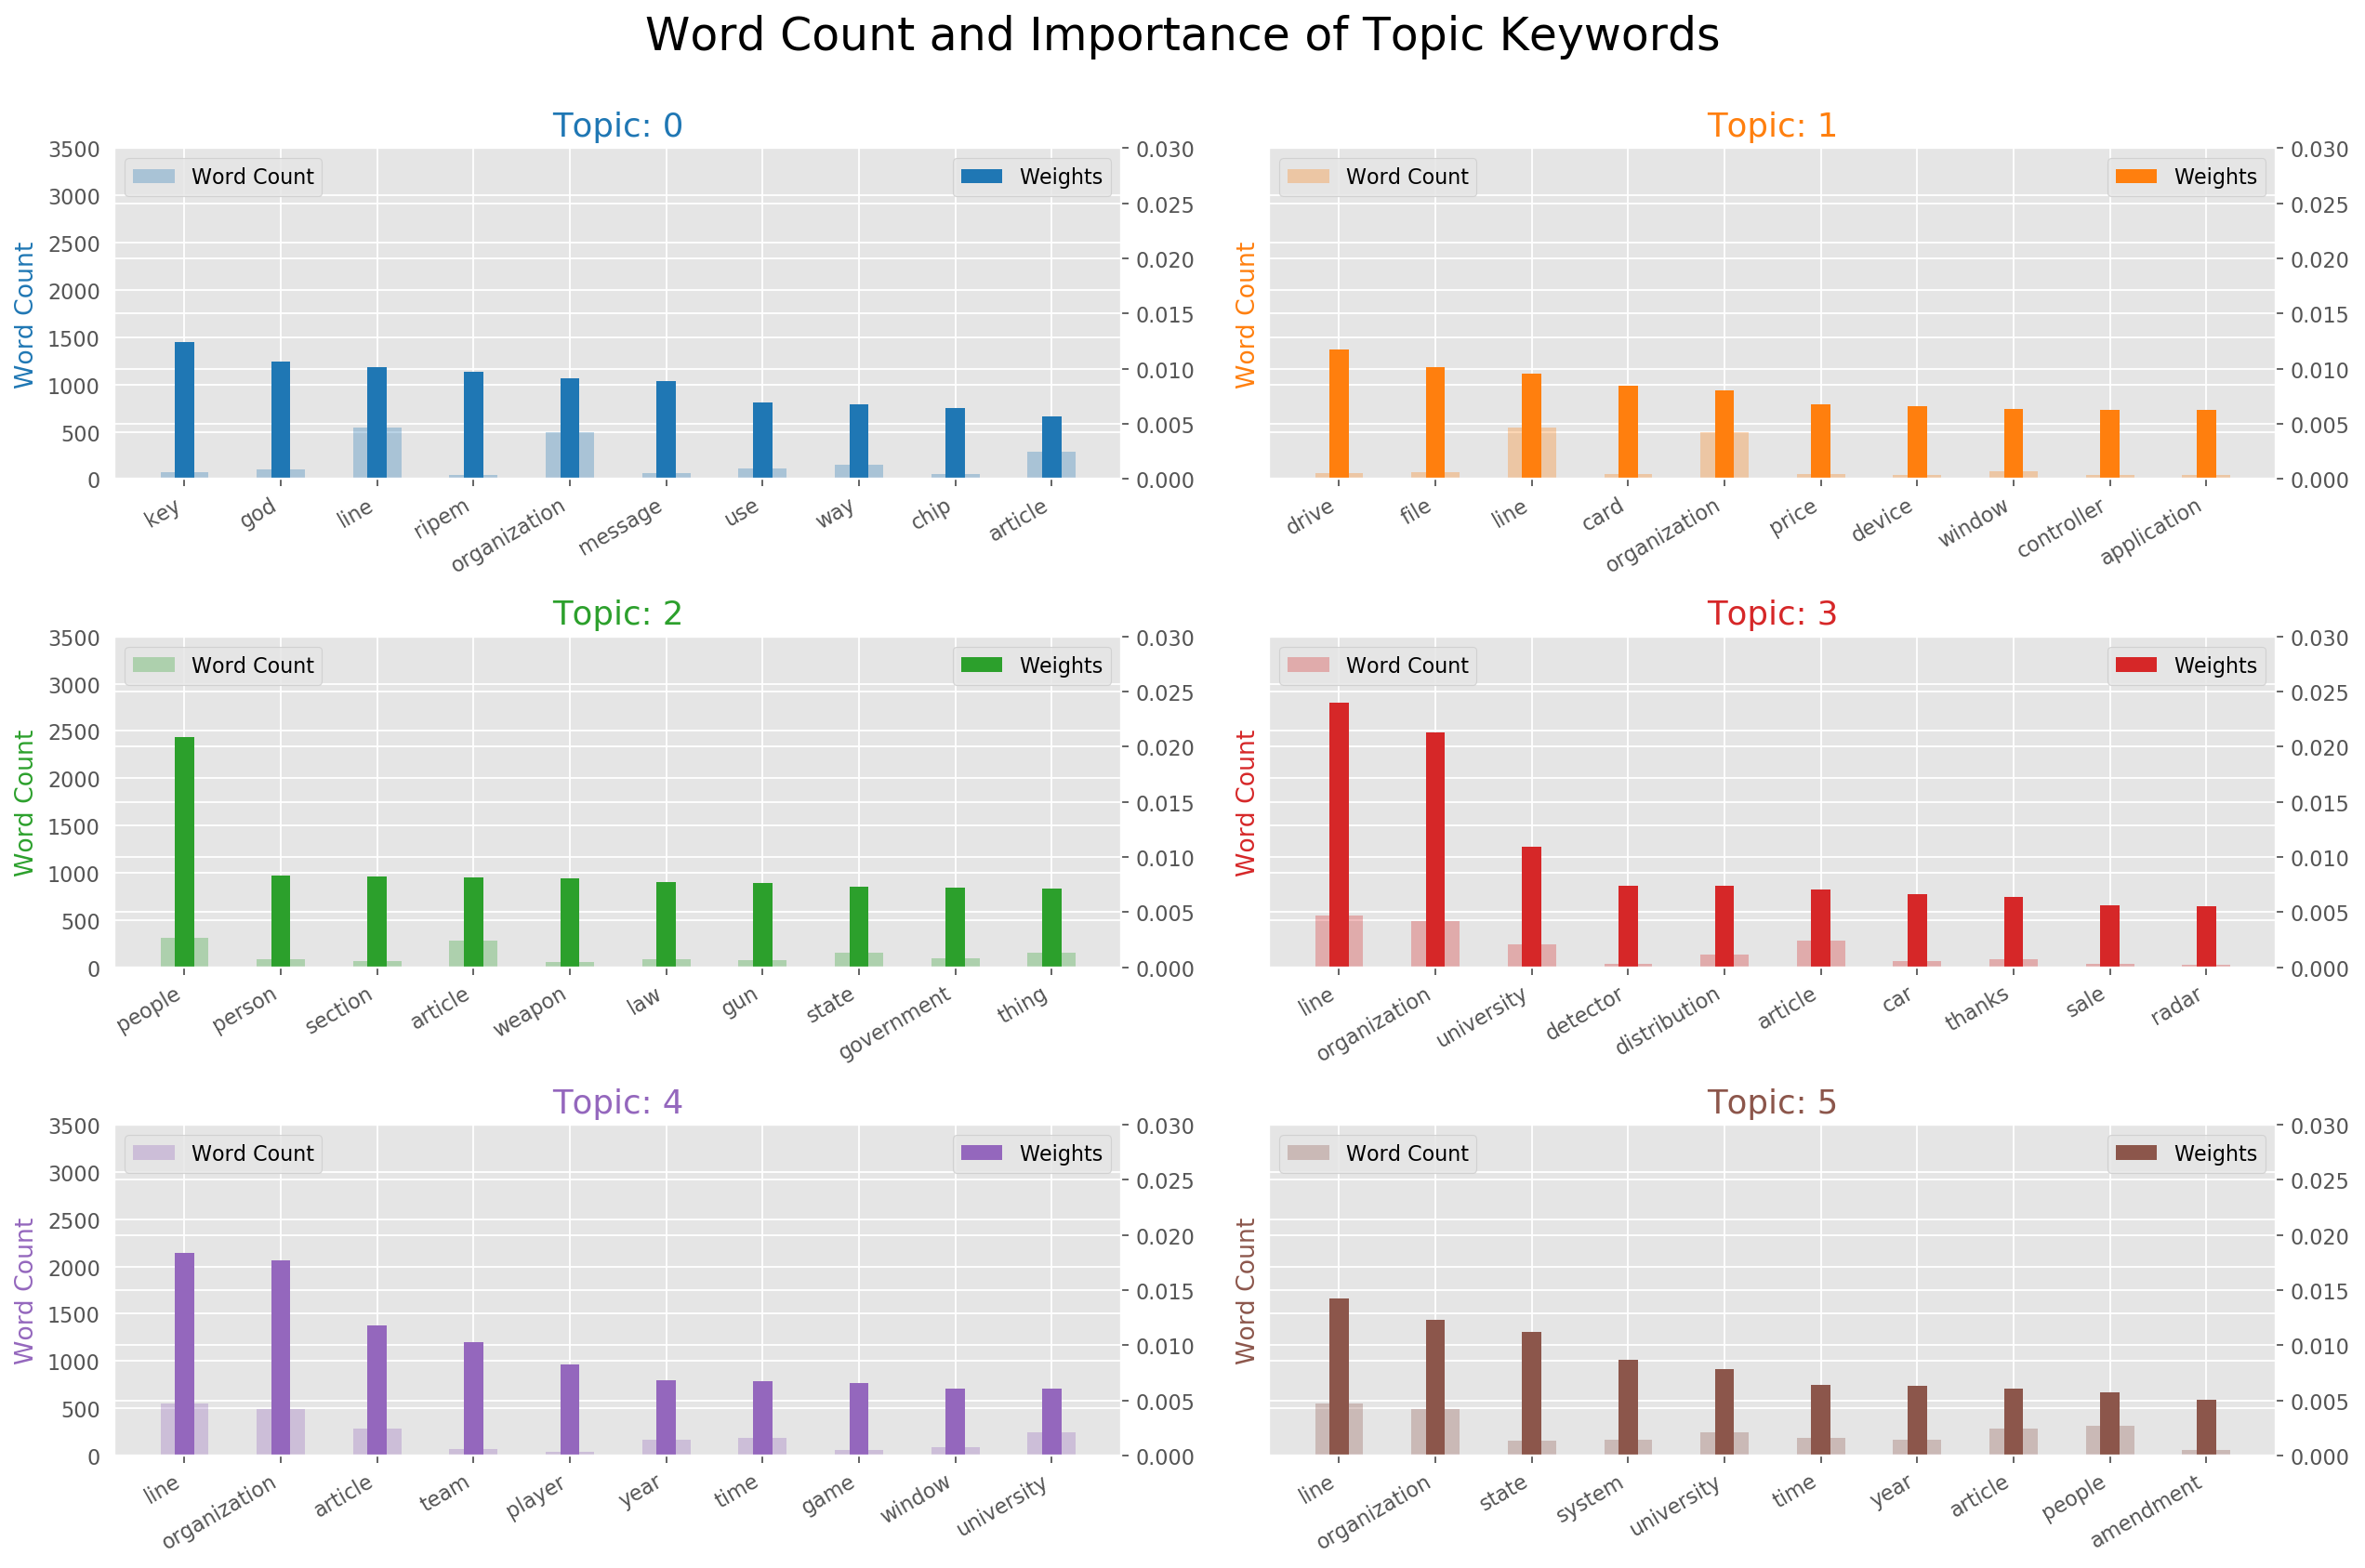

In [61]:
topics = model.show_topics(formatted=False)
data_flat = [w for w_list in tokenized_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

word_cloud_df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=word_cloud_df.loc[word_cloud_df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=word_cloud_df.loc[word_cloud_df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(word_cloud_df.loc[word_cloud_df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 5. Most discussed topics in the documents

In [62]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

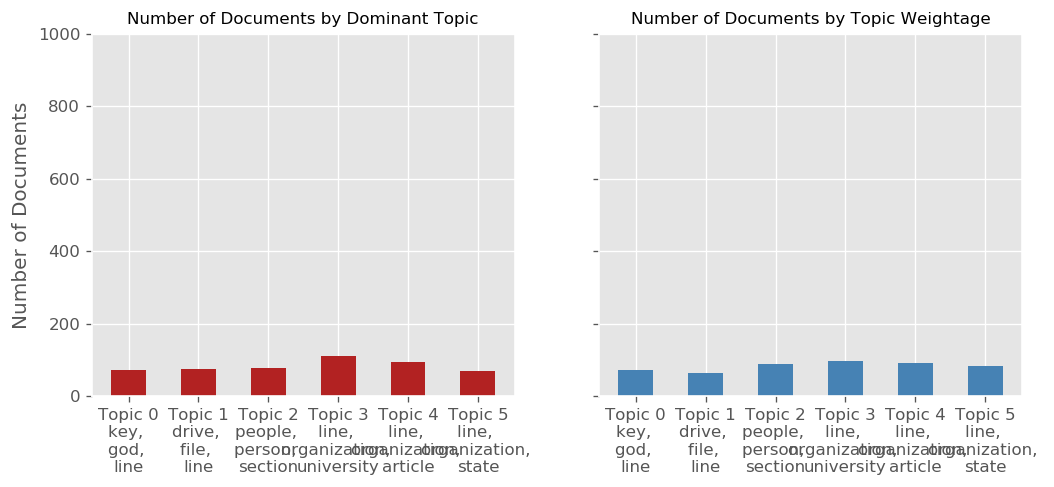

In [63]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()

### Model Tuning

Getting most optimal number of topics

In [64]:
limit=50; 
start=1; 
step=6;

In [65]:
def compute_optimal_topics(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [66]:
model_list, coherence_values = compute_optimal_topics(dictionary=id2word, corpus=corpus, texts=tokenized_data, start=start, limit=limit, step=step)

Vsualize

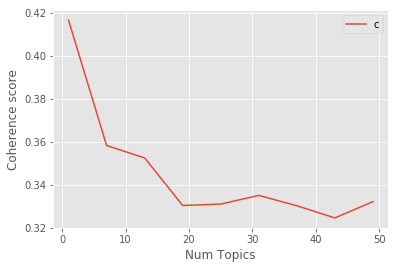

In [67]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Show topics and coherence values

In [68]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 1  is having Coherence Value of 0.4167
Num Topics = 7  is having Coherence Value of 0.3583
Num Topics = 13  is having Coherence Value of 0.3525
Num Topics = 19  is having Coherence Value of 0.3304
Num Topics = 25  is having Coherence Value of 0.3311
Num Topics = 31  is having Coherence Value of 0.3351
Num Topics = 37  is having Coherence Value of 0.3303
Num Topics = 43  is having Coherence Value of 0.3246
Num Topics = 49  is having Coherence Value of 0.3322


### Other Topic Modeling Algorithms Implemented in gensim

#### 1. LDA Mallet Model

MAchine Learning for LanguagE Toolkit (MALLET) is an open source toolkit developed by Andrew McCullum. It is a Java based package which is used for NLP tasks such as document classification, clustering, topic modeling e.t.c. Mallet provides Topic Modeling capabilities which contains an efficient, sampling-based implementations of LDA as well as Hierarchical LDA.

To use MALLET we must download it from here<a href='http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip'>mallet</a> and unzip it in a local directory.

Locate the Mallet file

In [69]:
# import os
# os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})

In [70]:
# mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet' # update this path to where you have unzipped your mallet file
# mallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [71]:
# # Compute Coherence Score
# coherence_mallet_model = CoherenceModel(model=mallet_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
# coherence_mallet_model.get_coherence()

#### 2. Hierarchical Dirichlet Process (HPD) Model

hierarchical Dirichlet process (HDP) is a nonparametric Bayesian approach to clustering grouped data.[1][2] It uses a Dirichlet process for each group of data, with the Dirichlet processes for all groups sharing a base distribution which is itself drawn from a Dirichlet process. This method allows groups to share statistical strength via sharing of clusters across groups. The base distribution being drawn from a Dirichlet process is important, because draws from a Dirichlet process are atomic probability measures, and the atoms will appear in all group-level Dirichlet processes <a href='https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process'>wikipedia</a>.

HDP is an extension of LDA model and is designed to handle where the number of mixture components (the number of "topics" in document-modeling terms) is not known.In HPD maximum number of topics can be unbounded and learned from the data rather than specified in advance.

Modeling with HDP

In [72]:
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word)

In [73]:
# Compute Coherence Score
coherence_hdp_model = CoherenceModel(model=hdp_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_hdp_model.get_coherence()

0.7236259132120573

#### 3. Latent Semantic Indexing (LSI)

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts. source:<a href='https://en.wikipedia.org/wiki/Latent_semantic_analysis#LSI_timeline'>wikipedia</a>

Modeling with LSI

In [74]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=6,chunksize=100)

In [75]:
# Compute Coherence Score
coherence_lsi_model = CoherenceModel(model=lsi_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_lsi_model.get_coherence()

0.4689247680381596

#### 4. sklearn-Latent Dirichlet allocation

LatentDirichletAllocation implements the online variational Bayes algorithm and supports both online and batch update methods. While the batch method updates variational variables after each full pass through the data, the online method updates variational variables from mini-batch data points.<a href='https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation'>sklearn</a>

In [76]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5, 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                            )

In [77]:

vectorized_data = vectorizer.fit_transform(data)


AttributeError: 'list' object has no attribute 'lower'

In [ ]:
# Build LDA Model
sklearn_lda_model = LatentDirichletAllocation(               
                                      max_iter=5,               
                                      learning_method='online',   
                                      random_state=50,          
                                      batch_size=56,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = sklearn_lda_model.fit_transform(vectorized_data)

Model attributes

In [ ]:
print(sklearn_lda_model)

Evaluate the model

We use Log likelyhoo and perplexity metrics. For Log likelihood where the higher value means the model performs better. For Perplexity the lower the value the better the model. 

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", sklearn_lda_model.score(vectorized_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", sklearn_lda_model.perplexity(vectorized_data))

#### 5. Non-negative Matrix Factorization

Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. NMF finds applications in such fields as astronomy, computer vision, document clustering, chemometrics, audio signal processing, recommender systems, and bioinformatics.<a href='https://en.wikipedia.org/wiki/Non-negative_matrix_factorization'>Wikipedia</a>

Non-negative matrix factorization is unsupervised learning technique for data mining used in extracting hidden patterns in data.

In [ ]:
nnmf=NMF(n_components = 6, random_state =100, alpha=0.1, l1_ratio = 0.5, init= 'nndsvd')

In [ ]:
nnmf.fit(vectorized_data)

### Conclusion

How to improve the model:<hr>
1. Improve on text processing.
2. The variety of topics the text talks about.
3. Topic modeling algorithm to use.
4. The number of topics to be retrieved from the algorithm.
5. The Model hyperparameter tuning.